In [2]:
from chemlab.util.ml_data import MLData
from chemlab.util.modify_inp import qchem_out_aimd_multi
import numpy as np

In [4]:



multi = qchem_out_aimd_multi()
multi.read_files([
    "./examples/phbdi/aimd_phbdi_nvt_1.out",
])



# 转换成 kcal/mol, Angstrom, kcal/mol/Angstrom

multi.export_numpy(prefix=prefix,
                   energy_unit="kcal",
                   distance_unit="ang",
                   force_unit=("kcal", "ang"))




(array([[[-2.13349988e+00, -3.09287158e+00,  9.48830430e-03],
         [-2.88553746e-01, -1.96650333e+00,  8.83486360e-03],
         [-1.35407194e+00, -9.72793620e-01,  8.26890670e-03],
         ...,
         [ 3.41631863e+00, -5.63045006e+00,  1.82262954e-02],
         [ 5.62719638e+00, -1.89148930e+00,  4.46584080e-03],
         [ 5.79696642e+00, -4.51729227e+00,  1.48621327e-02]],
 
        [[-2.13440974e+00, -3.09382628e+00,  7.91227430e-03],
         [-2.86478355e-01, -1.96424211e+00,  5.50838650e-03],
         [-1.35788591e+00, -9.72277096e-01,  2.43245010e-03],
         ...,
         [ 3.41032655e+00, -5.64502468e+00,  2.07469473e-02],
         [ 5.62643778e+00, -1.88158764e+00, -2.61004210e-03],
         [ 5.79838759e+00, -4.51843775e+00,  1.57015585e-02]],
 
        [[-2.13522701e+00, -3.09450434e+00,  6.45952780e-03],
         [-2.84732484e-01, -1.96219530e+00,  2.05188790e-03],
         [-1.36175900e+00, -9.72403531e-01, -3.22481130e-03],
         ...,
         [ 3.40584179e

In [3]:
# 1. 读取 (可扩展字段)
path = "./examples/tddft/phbdi/"
prefix = "./examples/tddft/phbdi/full_"
dataset = MLData(prefix=prefix, files=["coord","S1_energy","force","type"],energy_key="S1_energy")

# 2. 保存划分
train = 250
test = int(train/5)
val = int(train/5)
dataset.save_split(train, val, test, prefix=f"{path}{train}_")

# 3. 加载 split 并切片
split = np.load(f"{path}{train}_split.npz", allow_pickle=True)
train_data = dataset.get_split_data(split, part="idx_train")
val_data   = dataset.get_split_data(split, part="idx_val")
#energies = np.load(f"{prefix}energy.npy", allow_pickle=True)

Loaded dataset with 2800 frames, 27 atoms
Saved split to ./examples/tddft/phbdi/250_split.npz (idx_train=250, idx_val=50, idx_test=50)


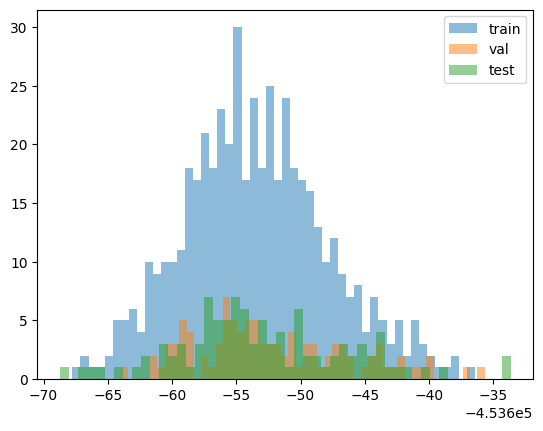

In [8]:
import matplotlib.pyplot as plt
path = "./examples/tddft/phbdi/"
prefix = "./examples/tddft/phbdi/full_"
train = 500
energies = np.load(f"{prefix}S1_energy.npy", allow_pickle=True)
split = np.load(f"{path}{train}_split.npz", allow_pickle=True)
plt.hist(energies[split["idx_train"]], bins=50, alpha=0.5, label="train")
plt.hist(energies[split["idx_val"]], bins=50, alpha=0.5, label="val")
plt.hist(energies[split["idx_test"]], bins=50, alpha=0.5, label="test")
plt.legend(); plt.show()
grads = np.load(f"{path}full_grad.npy")       # (N, Natoms, 3)
forces = np.load(f"{path}full_force.npy")       # (N, Natoms, 3)
#type = np.load(f"{path}full.npy")       # (N, Natoms, 3)


ΔE_ref vs ΔE_int correlation: -0.20391211747979474
Mean abs error: 0.029882074710401624


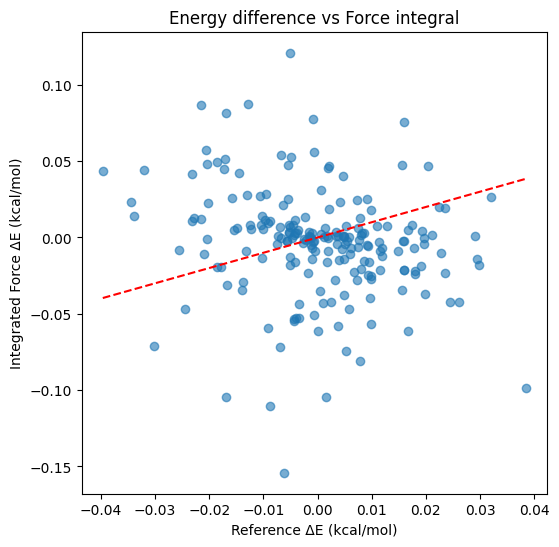

In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt

# --- 加载数据 ---
coords = np.load(f"{path}full_coord.npy")     # (N, Natoms, 3)
energies = np.load(f"{path}full_energy.npy")  # (N,)
grads = np.load(f"{path}full_grad.npy")       # (N, Natoms, 3)

# 注意：如果 grads 存的是 dE/dR，需要取负号；如果 grads 已经是力，就不要取负
forces = grads   # 如果 full_grad 已经是力，请把这行改成 forces = grads

N = len(coords)

def energy_diff_from_forces(R0, R1, F0, F1):
    """用梯形规则积分力估算能量差"""
    dR = R1 - R0  # (Natoms, 3)
    work0 = np.sum(F0 * dR)
    work1 = np.sum(F1 * dR)
    return -0.5 * (work0 + work1)

# --- 随机取一些片段做对比 ---
ncheck = 200
idxs = random.sample(range(N-1), ncheck)

dE_ref = []
dE_int = []

for i in idxs:
    R0, R1 = coords[i], coords[i+1]
    E0, E1 = energies[i], energies[i+1]
    F0, F1 = forces[i], forces[i+1]

    dE_ref.append(E1 - E0)
    dE_int.append(energy_diff_from_forces(R0, R1, F0, F1))

dE_ref = np.array(dE_ref)
dE_int = np.array(dE_int)

# --- 打印统计 ---
corr = np.corrcoef(dE_ref, dE_int)[0,1]
mae = np.mean(np.abs(dE_ref - dE_int))
print("ΔE_ref vs ΔE_int correlation:", corr)
print("Mean abs error:", mae)

# --- 可视化 ---
plt.figure(figsize=(6,6))
plt.scatter(dE_ref, dE_int, alpha=0.6)
plt.plot([dE_ref.min(), dE_ref.max()], [dE_ref.min(), dE_ref.max()], "r--")
plt.xlabel("Reference ΔE (kcal/mol)")
plt.ylabel("Integrated Force ΔE (kcal/mol)")
plt.title("Energy difference vs Force integral")
plt.show()


In [8]:
from scipy.stats import linregress
import numpy as np

# 用你刚才脚本算出来的数组
slope, intercept, r, *_ = linregress(dE_ref, dE_int)
print("slope =", slope)  # 这就是比例 k，理想应为 1

slope = 1.0001433943855342


[pair 10->1234]  ΔE_ref=-2.461737e+01  ΔE_int=-1.668757e+01  (hartree)
Correlation = 0.2431,  MAE = 9.258530e+01


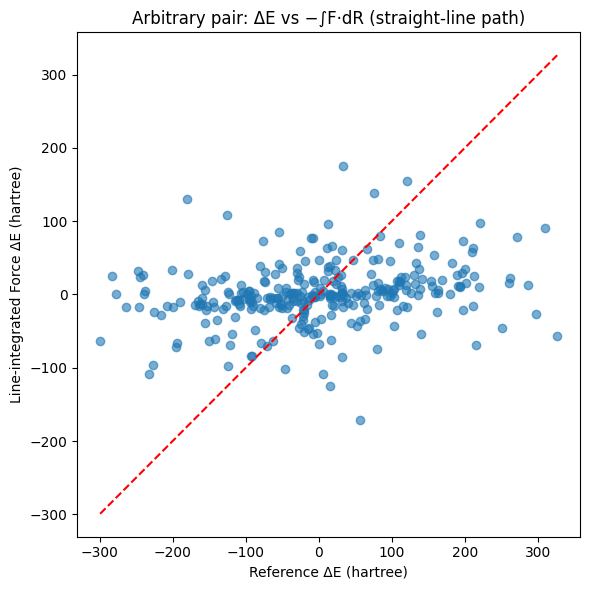

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import random


R = np.load(f"{path}full_coord.npy")        # (N, Natoms, 3)
E = np.load(f"{path}full_S1_energy.npy")* 14   # (N,)
G = np.load(f"{path}full_grad.npy")         # (N, Natoms, 3)

# 如果 G 存的是 dE/dR(梯度)，设为 True；如果已是力(−dE/dR)，设为 False
GRAD_IS_dEdR = True
F = -G if GRAD_IS_dEdR else G                  # (N, Natoms, 3)

# ====== Kabsch 刚体对齐（返回旋转矩阵与平移）======
def kabsch(P, Q):
    """
    P, Q: (Natoms, 3)  坐标；返回 R, t 使得 Q@R + t 对齐到 P
    """
    Pc = P - P.mean(axis=0)
    Qc = Q - Q.mean(axis=0)
    C = Qc.T @ Pc
    V, S, Wt = np.linalg.svd(C)
    d = np.sign(np.linalg.det(V @ Wt))
    D = np.diag([1.0, 1.0, d])
    Rmat = V @ D @ Wt
    t = P.mean(axis=0) - Q.mean(axis=0) @ Rmat
    return Rmat, t

def align_Q_to_P(P, Q, FQ=None):
    """
    把 Q 对齐到 P；若提供 FQ(力)，则一并旋转到同一坐标系。
    返回 Q_aligned, FQ_rot
    """
    Rmat, t = kabsch(P, Q)
    Q_aln = Q @ Rmat + t
    FQ_rot = FQ @ Rmat if FQ is not None else None
    return Q_aln, FQ_rot

# ====== 单对(i, j)的能量差与力积分 ======
def deltaE_by_pair(i, j, use_trapezoid=True):
    """
    返回 (ΔE_ref, ΔE_int) ；单位与你保存的文件一致（建议都在 hartree / Å）
    """
    Ri, Rj = R[i], R[j]
    Fi, Fj = F[i], F[j]

    # 刚体对齐第2帧坐标与力到第1帧坐标系
    Rj_aln, Fj_rot = align_Q_to_P(Ri, Rj, FQ=Fj)

    dR = Rj_aln - Ri  # (Natoms, 3)

    # 线积分近似（直线路径）：梯形规则或单点近似
    if use_trapezoid:
        work = -0.5 * (np.sum(Fi * dR) + np.sum(Fj_rot * dR))
    else:
        work = -np.sum(Fi * dR)  # 单点近似（用起点力）

    dE_ref = E[j] - E[i]
    dE_int = work
    return dE_ref, dE_int

# ====== 随机抽样多对做散点 ======
def scatter_random_pairs(n_pairs=300, use_trapezoid=True, seed=42):
    random.seed(seed)
    N = len(E)
    pairs = [tuple(sorted(random.sample(range(N), 2))) for _ in range(n_pairs)]
    dE_ref, dE_int = [], []
    for i, j in pairs:
        de_ref, de_int = deltaE_by_pair(i, j, use_trapezoid=use_trapezoid)
        dE_ref.append(de_ref); dE_int.append(de_int)
    dE_ref = np.array(dE_ref); dE_int = np.array(dE_int)

    corr = np.corrcoef(dE_ref, dE_int)[0, 1]
    mae = np.mean(np.abs(dE_ref - dE_int))
    print(f"Correlation = {corr:.4f},  MAE = {mae:.6e}")

    lo = min(dE_ref.min(), dE_int.min())
    hi = max(dE_ref.max(), dE_int.max())
    plt.figure(figsize=(6,6))
    plt.scatter(dE_ref, dE_int, alpha=0.6)
    plt.plot([lo, hi], [lo, hi], "r--")
    plt.xlabel("Reference ΔE (hartree)")
    plt.ylabel("Line-integrated Force ΔE (hartree)")
    plt.title("Arbitrary pair: ΔE vs −∫F·dR (straight-line path)")
    plt.tight_layout()
    plt.show()

# ====== 示例 ======
# 1) 指定两帧 i, j
i, j = 10, 1234
de_ref, de_int = deltaE_by_pair(i, j, use_trapezoid=True)
print(f"[pair {i}->{j}]  ΔE_ref={de_ref:.6e}  ΔE_int={de_int:.6e}  (hartree)")

# 2) 随机抽样若干对，画散点
scatter_random_pairs(n_pairs=300, use_trapezoid=True)


In [40]:
from scipy.stats import linregress
import numpy as np

# 用你刚才脚本算出来的数组
slope, intercept, r, *_ = linregress(dE_ref, dE_int)
print("slope =", slope)  # 这就是比例 k，理想应为 1

slope = -0.5416273908401177
